In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In data folder, there are two CSV files:
* Univariate dataset 'Monthly Number of Sales of Shampoo over 3-year period'
* Multivariate dataset 'Apple Stock data over 10 years'

In [2]:
shampoo = pd.read_csv("data/shampoo_sales.csv")

# There is no year value, only day-month - start Jan '2019'
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [3]:
shampoo.dtypes

Month     object
Sales    float64
dtype: object

In [4]:
shampoo['Temp_date'] = 0

initial_year = 2019

counter = 0

for indx, row in shampoo.iterrows():
    #print(indx)
    if counter < 12:
        year = initial_year
    elif counter >= 12 and counter < 24:
        year = initial_year + 1
    elif counter >= 24:
        year = initial_year + 2
    shampoo['Temp_date'].iloc[indx] = str(year) + "-" + shampoo['Month'].iloc[indx][2:]
    counter += 1
    

C:\Users\shmel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
shampoo['Month'] = shampoo['Temp_date']
shampoo.drop(columns='Temp_date', inplace=True)
shampoo['Month'] = shampoo['Month'] + "-" + "01"

shampoo.head()

,Month,Sales
0,2019-01-01,266.0
1,2019-02-01,145.9
2,2019-03-01,183.1
3,2019-04-01,119.3
4,2019-05-01,180.3


In [6]:
# Set Month as index
shampoo = shampoo.set_index(['Month'])

shampoo.head()

,Sales
Month,
2019-01-01,266.0
2019-02-01,145.9
2019-03-01,183.1
2019-04-01,119.3
2019-05-01,180.3


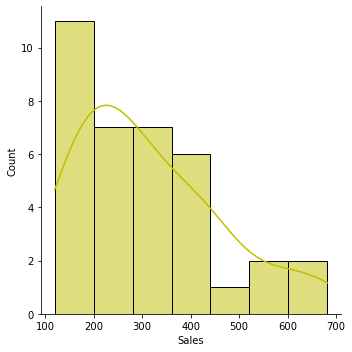

In [7]:
# Histogram of Sales amounts
# Normal distribution with cluster around 100-200 and 200-400
sns.displot(shampoo["Sales"], color='y', kde=True)

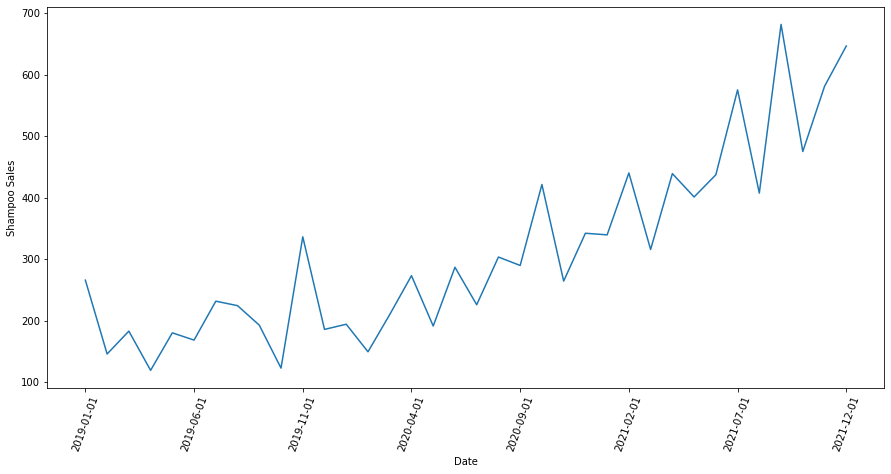

In [8]:
# Sales plotted against dateline - general trend with spikes around start of year and mid-year suggests seasonality
fg, ax = plt.subplots(1, 1, figsize=(15,7))

shampoo['Sales'].plot(ax=ax);
plt.xticks(rotation=70)
plt.xlabel('Date');
plt.ylabel('Shampoo Sales');

In [9]:
# Use adfuller() to check if Series is stationary (stationary signifies variance and mean stay constant over time)

def ad_test(data):
    dftest = adfuller(data, autolag='AIC')
    
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        

In [10]:
# If p < 0.05; Data is stationary
# If p > 0.05; Data is not stationary

ad_test(shampoo.Sales)

1. ADF :  3.0601420836411806
2. P-Value :  1.0
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 25
5. Critical Values :
	 1% :  -3.7238633119999998
	 5% :  -2.98648896
	 10% :  -2.6328004


### The *p-value* is greater than 0.05 so data is not stationary - make sure that number of differencing d=1

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

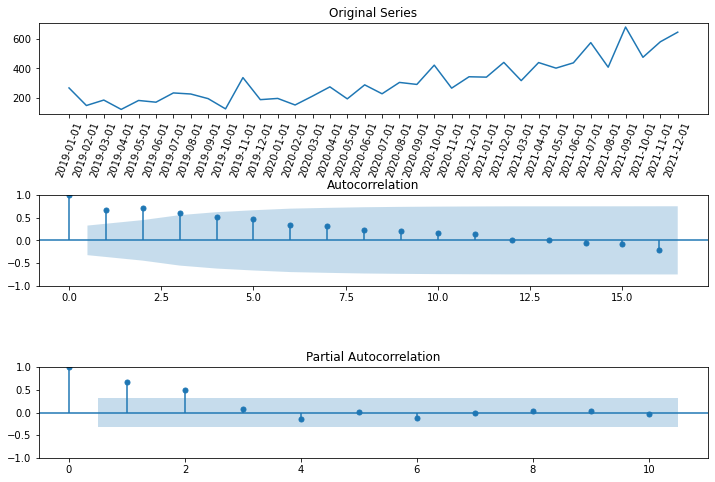

In [12]:
# Plot ACF and PACF plots to help ascertain order of AR and MA models
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.9)

ax[0].plot(shampoo.Sales)
ax[0].set_title('Original Series')
ax[0].tick_params(axis='x', rotation=70)
plot_acf(shampoo.Sales, ax=ax[1])
plot_pacf(shampoo.Sales, lags=10, method='ywm', ax=ax[2])
plt.show();

In [77]:
# ACF tails off with significant correlation upto 3 lags (since lag 3 is just on the threshold, it seems q=2)
# PACF also tails off with significant correlation around lags 1-2 (to be conservative, it seems p=1)

In [13]:
from pmdarima import auto_arima

In [14]:
# Use stepwise approach to confirm best order combinations for ARIMA model that gives minimum AIC (401)
stepwise_fit = auto_arima(shampoo['Sales'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=403.573, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best 

In [80]:
# ARIMA parameter order=(1,1,2) gives the lowest AIC score, as guessed by ACF/PACF plots above
# p=1
# d=1
# q=2

In [15]:
# Split train set into train-test sets to perform rolling forecast
X = shampoo.values

# Set up new train/test by creating slice of 2/3 to split train set (2/3 train set; 1/3 test set)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [16]:
# Set up new train set as nested array and rename to represent historic values
history = [x for x in train]

# Create empty predictions list
predictions = list()

In [17]:
# Fit rolling ARIMA models with order(1,1,2) to forecast on test set taken from training set
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y_pred, obs))

predicted=349.970807, expected=342.300000
predicted=286.003055, expected=339.700000
predicted=341.015454, expected=440.400000
predicted=341.819704, expected=315.900000
predicted=391.521270, expected=439.300000
predicted=339.753099, expected=401.300000
predicted=424.993908, expected=437.400000
predicted=387.268986, expected=575.500000
predicted=468.852028, expected=407.600000
predicted=503.761978, expected=682.000000
predicted=460.691662, expected=475.300000
predicted=613.988012, expected=581.300000
predicted=521.714871, expected=646.900000


In [18]:
# Validate model performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 90.986


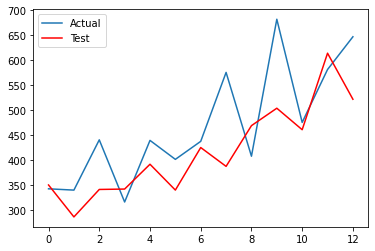

In [20]:
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Test')
plt.legend()
plt.show();

In [86]:
# Pretty good fit - not overfitting

In [21]:
# AIC has reduced which is good (395)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -193.662
Date:                Sat, 20 Aug 2022   AIC                            395.325
Time:                        08:00:41   BIC                            401.430
Sample:                             0   HQIC                           397.407
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6273      0.390     -1.608      0.108      -1.392       0.137
ma.L1         -0.2666      0.394     -0.677      0.498      -1.038       0.505
ma.L2          0.0234      0.330      0.071      0.9

In [25]:
# Fit new ARIMA model on entire dataset ARGH!
shampoo = shampoo.asfreq('M')

In [32]:
arima = ARIMA(X, order=(1, 1, 2))
arima_fit = arima.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -196.631
Date:                Sat, 20 Aug 2022   AIC                            401.263
Time:                        08:03:07   BIC                            407.484
Sample:                             0   HQIC                           403.411
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0894      0.346      0.258      0.796      -0.589       0.768
ma.L1         -1.3186      2.951     -0.447      0.655      -7.103       4.466
ma.L2          0.9944      4.393      0.226      0.8

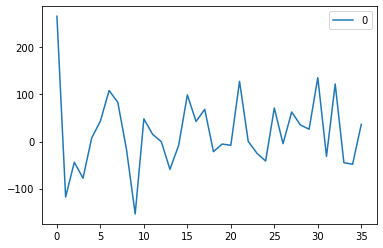

In [33]:
# Plot of residuals - still some errors around zero so bias exists
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.show();

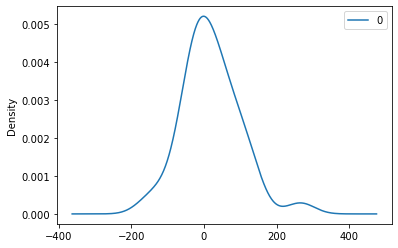

In [34]:
# Density plot of residuals - normal distribution of residuals near to zero
residuals.plot(kind='kde')
plt.show();

In [35]:
# Summary stats for residuals - mean is not zero (19.19) so still some noise in data
print(residuals.describe())

                0
count   36.000000
mean    19.191544
std     78.627714
min   -153.748261
25%    -26.525233
50%      3.911504
75%     64.073929
max    266.000000


In [37]:
# WHAT DOES PREDICT DO???
y_hat = arima_fit.predict(len(X), typ='levels')
print(y_hat)

[560.20377084]
